# Feedback Prize - Predicting Effective Arguments

When I checked other notebooks on Kaggle I notice BERT is very popular. In stead of BERT I will use Universal Sentence Encoder with triple inputs. I saw this kind of build in Tensorflow Course of https://www.kaggle.com/mrdbourke. Architecture referanced from https://arxiv.org/abs/1710.06071. Since, I am at the start of my Data Science journey all positive or negative feedbacks are appreciated about anything within the notebook.


## imports

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import string
from tensorflow.keras import layers
from tensorflow_hub import KerasLayer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import plot_model
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings("ignore")

## Getting data

In [3]:
train = pd.read_csv("/kaggle/input/feedback-prize-effectiveness/train.csv")
test = pd.read_csv("/kaggle/input/feedback-prize-effectiveness/test.csv")

In [4]:
display(train.head(), test.head())

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim


## EDA

In [5]:
# Check shapes
print(f"Shape of Training data {train.shape}")
print(f"Shape of Test data {test.shape}")
# Number of unique essay count
print(f"Number of unique essay count: {train.essay_id.nunique()}")

Shape of Training data (36765, 5)
Shape of Test data (10, 4)
Number of unique essay count: 4191


In [6]:
# Check a random essay
ran_uniq_id = random.choice(train.essay_id.unique())
for i in (train["discourse_text"].loc[train["essay_id"] == ran_uniq_id]):
  print(i)

I say that we use the technology that was created for helping emotional expressions of students in a classroom. 
I mean that would help so much. I'm a person that struggles to understand things when they are just said. I'm more of a hands on person but extra help and FACS would help a lot. This shows how humans have came long way in life,in the world. The FACS was created to help not only students but works or coustmers as well. 
To be able to tell how a person actually feels is like a skill that needs to be shared with the world. 
The reason I say we should use this technology is because in the text it says "in fact we humans perform this same impressive "calcuation" every day. 
For instance,you can probably tell how a friend is feeling simply by the look on her face. Of course,most of us would have trouble actually describing each facial trait that conveys happy,worried,etc". What all that means is when someone is having a bad day and you wanna help them but they say they are fine bu

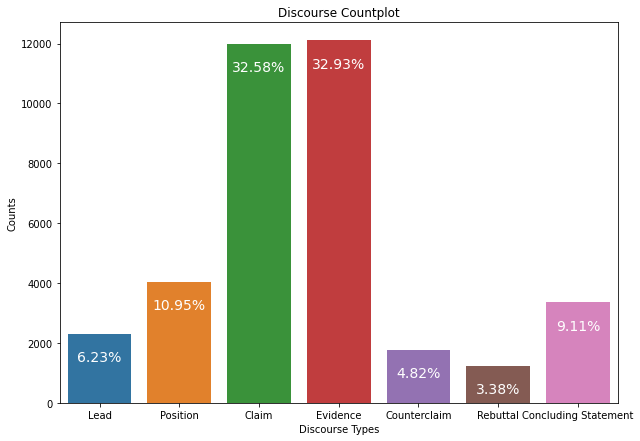

In [7]:
# Visualize unique Discourse types
plt.figure(figsize = (10,7))
ax = sns.countplot(x = train["discourse_type"])
for p in ax.patches:
    percentage = str(f"{(100 * p.get_height()/len(train)):.2f}") + "%"
    ax.annotate(f'\n{percentage}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=14)

plt.title("Discourse Countplot")
plt.ylabel("Counts")
plt.xlabel("Discourse Types");

### Target Investigation

In [8]:
# How many disclosure types?
print(f"Count of discourse_effectiveness types: {train.discourse_effectiveness.nunique()}\n")
print(f"discourse_effectiveness types are: {train.discourse_effectiveness.unique()}")

Count of discourse_effectiveness types: 3

discourse_effectiveness types are: ['Adequate' 'Ineffective' 'Effective']


In [9]:
# How many disclosure types?
print(f"Count of discourse_effectiveness types: {train.discourse_effectiveness.nunique()}\n")
print(f"discourse_effectiveness types are: {train.discourse_effectiveness.unique()}")

Count of discourse_effectiveness types: 3

discourse_effectiveness types are: ['Adequate' 'Ineffective' 'Effective']


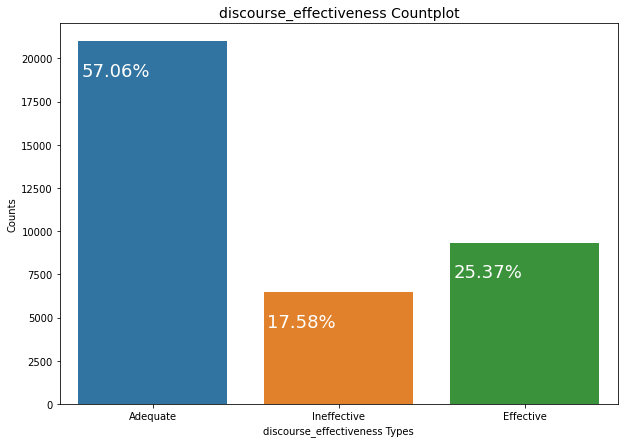

In [10]:
# Visualize unique discourse_effectiveness types
plt.figure(figsize = (10,7))
ax = sns.countplot(x = train["discourse_effectiveness"])
for p in ax.patches:
    percentage = str(f"{(100 * p.get_height()/len(train)):.2f}") + "%"
    ax.annotate(f'\n{percentage}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)
plt.title("discourse_effectiveness Countplot", fontsize = 14)
plt.ylabel("Counts")
plt.xlabel("discourse_effectiveness Types");

## Feature Engineering
Since `discourse_text` constructed as sentence splits of essays. In my opinion order of texts is important within same `essay_id`. Let's add line_num to our data

In [11]:
train["line_num"] = train.groupby("essay_id")["essay_id"].cumcount()+1
test["line_num"] = test.groupby("essay_id")["essay_id"].cumcount()+1
display(train.head(11))

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,line_num
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,1
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,2
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,3
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,4
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,5
5,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective,6
6,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate,7
7,4e472e2584fa,007ACE74B050,Everyone who thought it was made by alieans ev...,Counterclaim,Adequate,8
8,28a94d3ee425,007ACE74B050,Though people were not satified about how the ...,Concluding Statement,Adequate,9
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective,1


## Preprocessing 
Steps:
  * Lower the text
  * Remove digits
  * Remove Punctuation 

In [12]:
def preprocess_text(data):
  for i, text in enumerate(data["discourse_text"]):
      text =  text.lower()
      text = text.translate(str.maketrans("", "", string.digits))
      text = text.translate(str.maketrans("", "", string.punctuation))
      data["discourse_text"][i] = text  

In [13]:
preprocess_text(train), preprocess_text(test), display(train.head(), test.head())

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,line_num
0,0013cc385424,007ACE74B050,hi im isaac im going to be writing about how t...,Lead,Adequate,1
1,9704a709b505,007ACE74B050,on my perspective i think that the face is a n...,Position,Adequate,2
2,c22adee811b6,007ACE74B050,i think that the face is a natural landform be...,Claim,Adequate,3
3,a10d361e54e4,007ACE74B050,if life was on mars we would know by now the r...,Evidence,Adequate,4
4,db3e453ec4e2,007ACE74B050,people thought that the face was formed by ali...,Counterclaim,Adequate,5


,discourse_id,essay_id,discourse_text,discourse_type,line_num
0,a261b6e14276,D72CB1C11673,making choices in life can be very difficult p...,Lead,1
1,5a88900e7dc1,D72CB1C11673,seeking multiple opinions can help a person ma...,Position,2
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim,3
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim,4
4,93578d946723,D72CB1C11673,can be very helpful and beneficial,Claim,5


(None, None, None)

## Splitting train dataset into train and val 
Since in my opinion order of essays are important I will split dataset but will keep same essay elements together.

In [14]:
# Make Train And Val Split
np.random.seed(42)
split_size = int(0.1 * train["essay_id"].nunique()) # Split size 
random_id = random.sample(list(train["essay_id"].unique()), split_size) # choose random sample from unique ids 
is_val = np.isin(train.essay_id, random_id) # returns boolean list are these samples in d
idxs = np.arange(len(train))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
val = train.iloc[val_idxs]
train = train.iloc[trn_idxs]
train.shape, val.shape

((33189, 6), (3576, 6))

## Preparing for Multi Input Functional API

I will feed Neural Network with 3 inputs
* token_input: Texts from `discourse_text` column
* line_num: Rank of sentences within individual essays
* type_input: Categorical input of `discourse_type` column

### Label


In [15]:
# OneHotEncode, Target data
ohe = OneHotEncoder(sparse = False)
train_labels_ohe = ohe.fit_transform(train.discourse_effectiveness.to_numpy().reshape(-1,1))
val_labels_ohe = ohe.fit_transform(val.discourse_effectiveness.to_numpy().reshape(-1,1))



### Token

In [16]:
# Create sentence var for Token
train_sentences = train.discourse_text
val_sentences = val.discourse_text
test_sentences = test.discourse_text
train_sentences[:5]

0    hi im isaac im going to be writing about how t...
1    on my perspective i think that the face is a n...
2    i think that the face is a natural landform be...
3    if life was on mars we would know by now the r...
4    people thought that the face was formed by ali...
Name: discourse_text, dtype: object

In [17]:
# Download and load pretrained Universal Sentence Encoder
large_embed = KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                       input_shape = [],
                       dtype = tf.string,
                       trainable = False,
                       name = "USE")

2022-06-26 12:29:57.934678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 12:29:58.057447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 12:29:58.058427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-26 12:29:58.059697: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### line_num

In [18]:
# Check 98% percentile of line_num
line_num_98perc = np.percentile(train.line_num, 98)
line_num_98perc

14.0

In [19]:
# OneHotEncode line_num 

train_line_ohe = tf.one_hot(train.line_num.to_numpy(), depth = line_num_98perc)
val_line_ohe = tf.one_hot(val.line_num.to_numpy(), depth = line_num_98perc)
test_line_ohe = tf.one_hot(test.line_num.to_numpy(), depth = line_num_98perc)

### discourse_type


In [20]:
# OneHotEncode discourse_type
le = LabelEncoder()
train_distype_ohe = ohe.fit_transform(train.discourse_type.to_numpy().reshape(-1,1))
val_distype_ohe = ohe.fit_transform(val.discourse_type.to_numpy().reshape(-1,1))
test_distype_ohe = tf.one_hot(le.fit_transform(test.discourse_type), depth= 7)


### Let's Combine and Create tf.data

In [21]:
# Train dataset
train_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                 train_line_ohe,
                                                 train_distype_ohe))
train_label = tf.data.Dataset.from_tensor_slices(train_labels_ohe)
train_dataset = tf.data.Dataset.zip((train_data, train_label)).batch(32).prefetch(tf.data.AUTOTUNE)

# Val Dataset
val_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                 val_line_ohe,
                                                 val_distype_ohe))
val_label = tf.data.Dataset.from_tensor_slices(val_labels_ohe)
val_dataset = tf.data.Dataset.zip((val_data, val_label)).batch(32).prefetch(tf.data.AUTOTUNE)

# Test Dataset
test_dataset = [np.array(test_sentences), np.array(test_line_ohe), np.array(test_distype_ohe)] 

## Building quadruple input model with Functional API


In [22]:
# Token Model
token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_input")
token_embed = large_embed(token_inputs)
token_output = layers.Dense(128, activation = "relu")(token_embed)
token_model = tf.keras.Model(token_inputs, token_output)


# line_num Model
line_input = layers.Input(int(line_num_98perc,), dtype = tf.float32, name = "line_num_model")
line_output = layers.Dense(128, activation = "relu")(line_input)
line_model = tf.keras.Model(line_input, line_output)

# type Model
type_input = layers.Input(shape = (7,), dtype = tf.float64, name = "type_model")
type_output = layers.Dense(128, activation = "relu")(type_input)
type_model = tf.keras.Model(type_input,type_output)

# Concatenate all add dropout
z = layers.Concatenate()([token_model.output,
                        line_model.output,
                        type_model.output])

z = layers.Dense(256,activation = "relu")(z)

# output
model_output = layers.Dense(3, activation = "softmax")(z)

# Create model
model = tf.keras.Model([token_model.input,
                        line_model.input,
                        type_model.input],
                       model_output)

# Model Comple
model.compile(loss = "categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])


In [23]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
USE (KerasLayer)                (None, 512)          147354880   token_input[0][0]                
__________________________________________________________________________________________________
line_num_model (InputLayer)     [(None, 14)]         0                                            
__________________________________________________________________________________________________
type_model (InputLayer)         [(None, 7)]          0                                            
____________________________________________________________________________________________

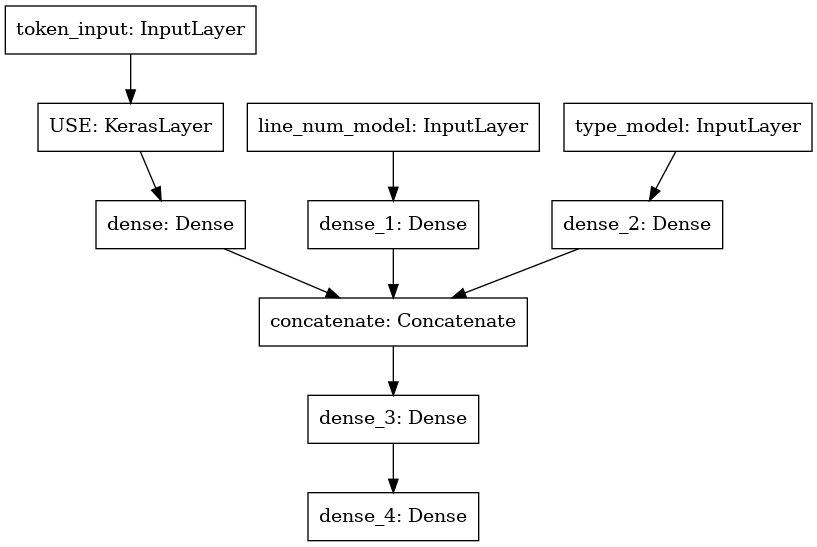

In [24]:
plot_model(model)

In [25]:
# Fit the model
history_model = model.fit(train_dataset,
                          steps_per_epoch = 200, 
                          epochs = 5,
                          validation_data = val_dataset)

Epoch 1/5
200/200 [==============================] - 55s 146ms/step - loss: 0.8537 - accuracy: 0.6114 - val_loss: 0.8488 - val_accuracy: 0.6225
Epoch 2/5
200/200 [==============================] - 23s 117ms/step - loss: 0.7780 - accuracy: 0.6481 - val_loss: 0.8370 - val_accuracy: 0.6306
Epoch 3/5
200/200 [==============================] - 22s 110ms/step - loss: 0.8128 - accuracy: 0.6413 - val_loss: 0.7837 - val_accuracy: 0.6446
Epoch 4/5
200/200 [==============================] - 22s 110ms/step - loss: 0.7975 - accuracy: 0.6503 - val_loss: 0.7811 - val_accuracy: 0.6429
Epoch 5/5
200/200 [==============================] - 23s 115ms/step - loss: 0.7722 - accuracy: 0.6505 - val_loss: 0.7658 - val_accuracy: 0.6681


In [26]:
# Evaluate on val_dataset
model.evaluate(val_dataset)

112/112 [==============================] - 8s 73ms/step - loss: 0.7658 - accuracy: 0.6681


[0.7657804489135742, 0.6680648922920227]

In [27]:
# Predict on dummified test dataset
preds = model.predict(test_dataset)
preds

array([[0.61658454, 0.14733127, 0.2360842 ],
       [0.60158855, 0.35108805, 0.04732341],
       [0.41481298, 0.56343883, 0.02174821],
       [0.53415823, 0.40006456, 0.06577722],
       [0.35103372, 0.62900776, 0.01995856],
       [0.19290267, 0.80344003, 0.00365741],
       [0.17876893, 0.8180946 , 0.00313646],
       [0.3386096 , 0.6416953 , 0.01969514],
       [0.1934863 , 0.8027246 , 0.00378908],
       [0.35837993, 0.6321446 , 0.00947551]], dtype=float32)

In [28]:
# Check Sample Submission
sample_sub = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/sample_submission.csv')
sample_sub.head()

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.20,0.60,0.40
1,5a88900e7dc1,3.00,6.00,1.00
2,9790d835736b,1.00,2.00,3.00
3,75ce6d68b67b,0.33,0.34,0.33
4,93578d946723,0.01,0.24,0.47


In [29]:
# Create submisson csv 
my_submission = pd.DataFrame({
    "discourse_id": test.discourse_id,
    "Ineffective": preds[:,0],
    "Adequate": preds[:,1],
    "Effective": preds[:,2]
})
my_submission

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.616585,0.147331,0.236084
1,5a88900e7dc1,0.601589,0.351088,0.047323
2,9790d835736b,0.414813,0.563439,0.021748
3,75ce6d68b67b,0.534158,0.400065,0.065777
4,93578d946723,0.351034,0.629008,0.019959
5,2e214524dbe3,0.192903,0.803440,0.003657
6,84812fc2ab9f,0.178769,0.818095,0.003136
7,c668ff840720,0.338610,0.641695,0.019695
8,739a6d00f44a,0.193486,0.802725,0.003789
9,bcfae2c9a244,0.358380,0.632145,0.009476


In [30]:
my_submission.to_csv('submission.csv',index=False)

Thank you for checking my work, please let me know any kind of improvements I can make.